In [29]:
import numpy as np
import pandas as pd

import os
datapath = "/home/xiangyu/kaggle/d2l/multilayerperceptrons/data"
for dirname, _, filenames in os.walk(datapath):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/home/xiangyu/kaggle/d2l/multilayerperceptrons/data/fashion-mnist_test.csv
/home/xiangyu/kaggle/d2l/multilayerperceptrons/data/t10k-images-idx3-ubyte
/home/xiangyu/kaggle/d2l/multilayerperceptrons/data/fashion-mnist_train.csv
/home/xiangyu/kaggle/d2l/multilayerperceptrons/data/train-images-idx3-ubyte
/home/xiangyu/kaggle/d2l/multilayerperceptrons/data/t10k-labels-idx1-ubyte
/home/xiangyu/kaggle/d2l/multilayerperceptrons/data/train-labels-idx1-ubyte


In [30]:
train = pd.read_csv(os.path.join(datapath, "fashion-mnist_train.csv"))
test = pd.read_csv(os.path.join(datapath, "fashion-mnist_test.csv"))

In [31]:
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [32]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [33]:
device = 'cuda:0'
batch_size = 128
epoch = 50

In [34]:
class FashionDataset(Dataset):
    def __init__(self, device, dataset:pd.DataFrame):
        super(Dataset, self).__init__()
        self.x = torch.tensor(dataset.drop(['label'], axis=1).values, dtype=torch.float32).to(device)
        self.y = torch.tensor(dataset['label'].values).to(device)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

In [35]:
trainset = FashionDataset(device=device, dataset=train)
testset = FashionDataset(device=device, dataset=test)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size)

In [36]:
class Model(nn.Module):
    def __init__(self, input, hidden, output, dropout):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input, hidden), 
            nn.ReLU(), 
            nn.Dropout(dropout), 
            nn.Linear(hidden, hidden), 
            nn.ReLU(), 
            nn.Dropout(dropout), 
            nn.Linear(hidden, output), 
        )

    def forward(self, x):
        return self.net(x)

In [37]:
class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, num_epoch, trainloader, testloader):
        trainloss = []
        testloss = []
        for i in range(num_epoch):
            loss = self.train_epoch(trainloader)
            print(f'training {i} epoch: loss is {loss}')
            trainloss.append(loss)
            acc = self.test(testloader)
            print(f'test acc rate {acc}')
            testloss.append(acc)
        plt.plot(trainloss, label='train_loss')
        plt.plot(testloss, label='test_acc')
        plt.ylim(0, 1)
        plt.xlabel('epoch')
        plt.ylabel('loss/acc')
        plt.legend()
        plt.show()

    def train_epoch(self, dataloader):
        total_loss = 0.0
        for x, y in dataloader:
            total_loss += self.train_step(x, y)
        return total_loss / len(dataloader)

    def train_step(self, inputs, targets):
        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def test(self, dataloader):
        total_acc = 0.0
        for x, y in dataloader:
            total_acc += self.test_step(x, y)
        return total_acc / len(dataloader)
    
    def test_step(self, inputs, targets):
        self.model.eval()
        outputs = self.model(inputs)
        argmax = torch.argmax(outputs, dim=-1)
        return (torch.sum(argmax == targets) / len(targets)).item()

In [38]:
model = Model(784, 2048, len(label_names), 0.5).to(device)
optimizer = torch.optim.SGD(model.parameters(), 0.001)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, criterion)

training 0 epoch: loss is 2.281925835398469
test acc rate 0.8318829113924051
training 1 epoch: loss is 0.6977690633680267
test acc rate 0.8320806962025317
training 2 epoch: loss is 0.5944862068334876
test acc rate 0.8562104430379747
training 3 epoch: loss is 0.5403551601016445
test acc rate 0.8566060126582279
training 4 epoch: loss is 0.5074883831589461
test acc rate 0.8594738924050633
training 5 epoch: loss is 0.4827405242269227
test acc rate 0.8644185126582279
training 6 epoch: loss is 0.4643358484641321
test acc rate 0.8679786392405063
training 7 epoch: loss is 0.4524272476940521
test acc rate 0.8707476265822784
training 8 epoch: loss is 0.43826906923164943
test acc rate 0.875
training 9 epoch: loss is 0.42913601749233093
test acc rate 0.875692246835443
training 10 epoch: loss is 0.419853911947594
test acc rate 0.8730221518987342
training 11 epoch: loss is 0.4128252302469221
test acc rate 0.8757911392405063
training 12 epoch: loss is 0.4056470104372069
test acc rate 0.87628560126582

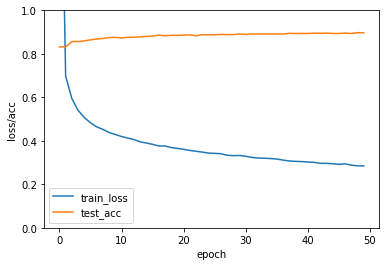

In [39]:
#Todo: 使用animation进行图的实时更新
trainer.train(num_epoch=epoch, trainloader=trainloader, testloader=testloader)

In [40]:
hidden_num = [8, 10, 12, 14, 16, 32, 64, 128, 256, 512, 1024, 2048]
acc = [0.307, 0.334, 0.734, 0.774, 0.829, 0.813, 0.862, 0.866, 0.860, 0.865, 0.869, 0.866]